In [1]:
import sys

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "..")

# Or otherwise install trulens.
# !{sys.executable} -m pip install trulens

# Install transformers / huggingface.
!{sys.executable} -m pip install transformers

from IPython.display import display
import torch

# Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Before getting started, familiarize yourself with the general Truera API as demonstrated in the [intro notebook using pytorch](intro_demo_pytorch.ipynb).

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

This model quantifies tweets (or really any text you give it) according to its sentiment: positive, negative, or neutral. Lets try it out on some examples.

In [3]:
sentences = ["I'm so happy!", "I'm so sad!", "I cannot tell whether I should be happy or sad!", "meh"]

# Input sentences need to be tokenized first.

inputs = task.tokenizer(sentences, padding=True, return_tensors="pt").to(task.device) # pt refers to pytorch tensor

# The tokenizer gives us vocabulary indexes for each input token (in this case,
# words and some word parts like the "'m" part of "I'm" are tokens).

print(inputs)

# Decode helps inspecting the tokenization produced:

print(task.tokenizer.batch_decode(torch.flatten(inputs['input_ids'])))
# Normally decode would give us a single string for each sentence but we would
# not be able to see some of the non-word tokens there. Flattening first gives
# us a string for each input_id.

{'input_ids': tensor([[   0,  100,  437,   98, 1372,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100,  437,   98, 5074,  328,    2,    1,    1,    1,    1,    1,
            1],
        [   0,  100, 1395, 1137,  549,   38,  197,   28, 1372,   50, 5074,  328,
            2],
        [   0, 1794,  298,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}
['<s>', 'I', "'m", ' so', ' happy', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', "'m", ' so', ' sad', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<s>', 'I', ' cannot', ' tell', ' whether', ' I', ' should', ' be', ' happy', ' or', ' sad', '!', '</s>', '<s>', 'me', 'h', '</s>', '<pad>', '<

Evaluating huggingface models is straight-forward if we use the structure produced by the tokenizer.

In [4]:
outputs = task.model(**inputs)

print(outputs)

# From logits we can extract the most likely class for each sentence and its readable label.

predictions = [task.labels[i] for i in outputs.logits.argmax(axis=1)]

for sentence, logits, prediction in zip(sentences, outputs.logits, predictions):
    print(logits.to('cpu').detach().numpy(), prediction, sentence)

SequenceClassifierOutput(loss=None, logits=tensor([[-2.3216, -0.8766,  4.0705],
        [ 2.5746, -0.4018, -2.1475],
        [ 0.5976,  0.3778, -0.7692],
        [-0.2266,  0.6010, -0.2010]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
[-2.3215542 -0.8765632  4.070538 ] positive I'm so happy!
[ 2.5745866  -0.40179724 -2.1475189 ] negative I'm so sad!
[ 0.59755296  0.37775993 -0.7692062 ] negative I cannot tell whether I should be happy or sad!
[-0.22658335  0.60099953 -0.20098346] neutral meh


# Model Wrapper

As in the prior notebooks, we need to wrap the pytorch model with the appropriate Trulens functionality. Here we specify the maximum input size (in terms of tokens) each tweet may have.

In [5]:
from trulens.nn.models import get_model_wrapper
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients
from trulens.nn.attribution import Cut, OutputCut
from trulens.utils.typing import ModelInputs

task.wrapper = get_model_wrapper(task.model, input_shape=(None, task.tokenizer.model_max_length), device=task.device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.
INFO: Changing backend from None to Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.
DEBUG: Input dtype was not passed in. Defaulting to `torch.float32`.


# Attributions

Applying integrated gradents to the sentiment model is similar as in the prior notebooks except special considerations need to be made for the cuts used as the targets of the attribution (i.e. what do we want to assign importance to). As you may have noted above, the model takes as input integer indexes associated with tokens. As we cannot take gradient with respect to these, we use an alternative: the embedding representation of those same inputs. To instantiate trulens with this regard, we need to find inspect the layer names inside our model:

In [6]:
task.wrapper.print_layer_names()

'roberta_embeddings_word_embeddings':	Embedding(50265, 768, padding_idx=1)
'roberta_embeddings_position_embeddings':	Embedding(514, 768, padding_idx=1)
'roberta_embeddings_token_type_embeddings':	Embedding(1, 768)
'roberta_embeddings_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_embeddings_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_self_query':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_key':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_value':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_self_dropout':	Dropout(p=0.1, inplace=False)
'roberta_encoder_layer_0_attention_output_dense':	Linear(in_features=768, out_features=768, bias=True)
'roberta_encoder_layer_0_attention_output_LayerNorm':	LayerNorm((768,), eps=1e-05, elementwise_affine=True)
'roberta_encoder_layer_0_attention_output_dropou

## Parameters

Above, `roberta_embeddings_word_embeddings` is the layer that produces a continuous representation of each input token so we will use that layer as the one defining the **distribution of interest**. While most neural NLP models contain a token embedding, the layer name will differ.

The second thing to note is the form of model outputs. Specifically, outputs are structures which contain a 'logits' attribute that stores the model scores.

Putting these things together, we instantiate `IntegratedGradients` to attribute each embedding dimension to the maximum class (i.e. the predicted class).

In [7]:
infl_max = IntegratedGradients(
    model = task.wrapper,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

In [8]:
# Alternatively we can look at a particular class:

infl_positive = IntegratedGradients(
    model = task.wrapper,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

Getting attributions uses the same call as model evaluation.

In [9]:
attrs = infl_max.attributions(**inputs)

for token_ids, token_attr in zip(inputs['input_ids'], attrs):
    for token_id, token_attr in zip(token_ids, token_attr):
        # Not that each `word_attr` has a magnitude for each of the embedding
        # dimensions, of which there are many. We aggregate them for easier
        # interpretation and display.
        attr = token_attr.sum()

        word = task.tokenizer.decode(token_id)

        print(f"{word}({attr:0.3f})", end=' ')

    print()

        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        ...,
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        [   0, 1794,  298,  ...,    1,    1,    1]], device='cuda:0') is not differentiable.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') is not differentiable.


<s>(0.025) I(0.154) 'm(0.173)  so(0.228)  happy(0.222) !(0.121) </s>(0.016) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 
<s>(0.022) I(0.092) 'm(0.049)  so(0.647)  sad(0.368) !(-0.027) </s>(-0.134) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 
<s>(-0.014) I(-0.046)  cannot(-0.277)  tell(-0.026)  whether(0.048)  I(-0.035)  should(0.023)  be(-0.036)  happy(-0.096)  or(-0.144)  sad(-0.265) !(-0.143) </s>(-0.295) 
<s>(0.028) me(-0.074) h(-0.180) </s>(-0.097) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) <pad>(0.000) 


A listing as above is not very readable so Trulens comes with some utilities to present token influences a bit more concisely. First we need to set up a few parameters to make use of it:

In [10]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=lambda sentences: ModelInputs(kwargs=task.tokenizer(sentences, padding=True, return_tensors='pt')).map(lambda t: t.to(task.device)),
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x.kwargs['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

print("QOI = MAX PREDICTION")
display(V.token_attribution(sentences, infl_max))

print("QOI = POSITIVE")
display(V.token_attribution(sentences, infl_positive))

        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        ...,
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        [   0, 1794,  298,  ...,    1,    1,    1]], device='cuda:0') is not differentiable.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') is not differentiable.


QOI = MAX PREDICTION


        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        ...,
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        [   0, 1794,  298,  ...,    1,    1,    1]], device='cuda:0') is not differentiable.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') is not differentiable.


QOI = POSITIVE


# Baselines

We see in the above results that special tokens such as the sentence end **&lt;/s&gt;** contributes are found to contribute a lot to the model outputs. While this may be useful in some contexts, we are more interested in the contributions of the actual words in these sentences. To focus on the words more, we need to adjust the **baseline** used in the integrated gradients computation. By default in the instantiation so far, the baseline for each token is a zero vector of the same shape as its embedding. By making the basaeline be identicaly to the explained instances on special tokens, we can rid their impact from our measurement. Trulens provides a utility for this purpose in terms of `token_baseline` which constructs for you the methods to compute the appropriate baseline. 

In [11]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.sep_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

We can now inspect the baselines on some example sentences. The first method returned by `token_baseline` gives us token ids to inspect while the second gives us the embeddings of the baseline which we will pass to the attributions method.

In [12]:
print("originals=", task.tokenizer.batch_decode(inputs['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(args=[], kwargs=inputs))
print("baselines=", task.tokenizer.batch_decode(baseline_word_ids))

originals= ["<s>I'm so happy!</s><pad><pad><pad><pad><pad><pad>", "<s>I'm so sad!</s><pad><pad><pad><pad><pad><pad>", '<s>I cannot tell whether I should be happy or sad!</s>', '<s>meh</s><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
baselines= ['<s><pad><pad><pad><pad><pad></s><pad><pad><pad><pad><pad><pad>', '<s><pad><pad><pad><pad><pad></s><pad><pad><pad><pad><pad><pad>', '<s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad></s>', '<s><pad><pad></s><pad><pad><pad><pad><pad><pad><pad><pad><pad>']


In [13]:
infl_positive_baseline = IntegratedGradients(
    model = task.wrapper,
    resolution=50,
    baseline = inputs_baseline_embeddings,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

print("QOI = POSITIVE WITH BASELINE")
display(V.token_attribution(sentences, infl_positive_baseline))

        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        ...,
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        [   0, 1794,  298,  ...,    1,    1,    1]], device='cuda:0') is not differentiable.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') is not differentiable.


QOI = POSITIVE WITH BASELINE


As we see, the baseline eliminated the measurement of contribution of the special tokens.

# Internal Attributions

In [14]:
infl_positive_baseline_internal = IntegratedGradients(
    model = task.wrapper,
    resolution=50,
    baseline = inputs_baseline_embeddings,
    doi_cut=Cut('roberta_encoder_layer_3_output_dense'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

In [15]:
attr = infl_positive_baseline_internal.attributions(**inputs)

        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        ...,
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0,  100, 1395,  ..., 5074,  328,    2],
        [   0, 1794,  298,  ...,    1,    1,    1]], device='cuda:0') is not differentiable.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0') is not differentiable.


In [19]:
attr.shape

(4, 13, 768)

In [54]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[0:4:1, 0:13:1, 0:768:1]
values = attr[X, Y, Z]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=values.min(),
    isomax=values.max(),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    ))
fig.show()

In [78]:
attr2d = attr.reshape((attr.shape[0] * attr.shape[1] * 4, attr.shape[2] // 4))

In [79]:
attr2d_norm = attr2d
attr2d_norm -= attr2d_norm.min()
attr2d_norm /= attr2d_norm.max()

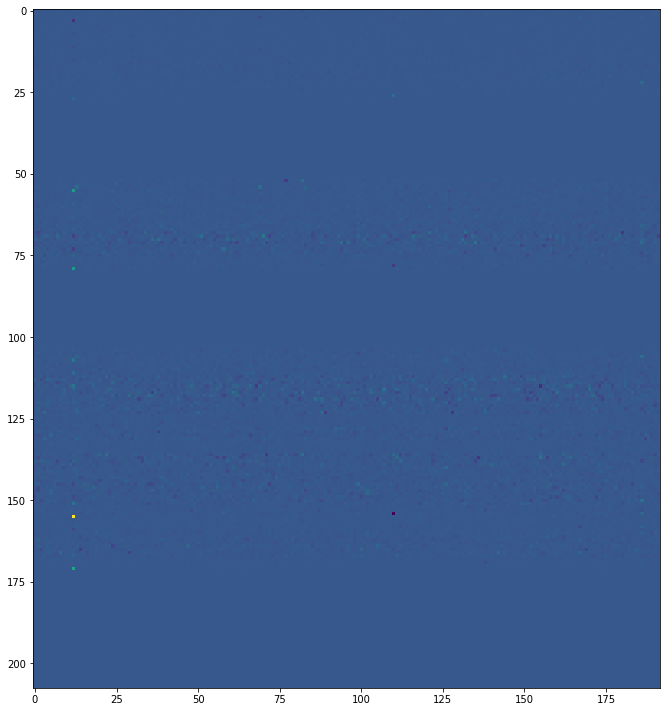

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,10))
ax = fig.subplots(1,1)

ax.imshow(attr2d_norm)
fig.tight_layout()

In [57]:
attr2d_norm.max()

1.0